# Stage 5 (2.2 lgbm_2_stage_model)

# Импортируем библиотеки

In [1]:
from typing import Dict, Any
import warnings


# ----------------
# Data processing
# ----------------
import dill

import numpy as np
import pandas as pd

from tqdm.auto import tqdm


# ---------------------
# RecSys models imports
# ---------------------

from lightgbm import LGBMRanker


# --------------
# Plotting libs
# --------------
import plotly.express as px
import matplotlib.pyplot as plt
import seaborn as sns
import shap


# -------------------
# Metrics Evaluation
# -------------------
from metrics import RecommenderMetrics


# -------------------
# Utils
# -------------------
from utils import get_lightgbm_group, add_score_and_rank


warnings.filterwarnings("ignore")
sns.set_theme(style="whitegrid")

RANDOM_STATE = 42

# Импортируем пути

In [2]:
data_path = "../data_closed/"

In [3]:
models_path = "../models/"

In [4]:
candidates_data_path = models_path + "candidates_data/"

# Модель второго уровня (ранкер)

## Ranker Data

In [5]:
# Загрузим таблицу ranker_train
with open(data_path + "ranker_train_final.dill", "rb") as f:
    ranker_train = dill.load(f)
    
# Загрузим таблицу ranker_val
with open(data_path + "ranker_val_final.dill", "rb") as f:
    ranker_val = dill.load(f)

### Выбираем колонки на которых будет обучаться ранкер

In [6]:
ranker_train.columns

Index(['user_id', 'item_id', 'ui_inter', 'cos_score', 'cos_rank', 'bm25_score',
       'bm25_rank', 'tfidf_score', 'tfidf_rank', 'lfm_score', 'lfm_rank',
       'user_hist', 'user_avg_pop', 'user_last_pop', 'title_len', 'descr_len',
       'title_word_len', 'descr_word_len', 'txt_emb_pca_0', 'txt_emb_pca_1',
       'txt_emb_pca_2', 'txt_emb_pca_3', 'txt_emb_pca_4', 'txt_emb_pca_5',
       'txt_emb_pca_6', 'txt_emb_pca_7', 'txt_emb_pca_8', 'txt_emb_pca_9',
       'brand', 'color', 'closure', 'country', 'cut', 'height', 'length',
       'material', 'model', 'neckline', 'pattern', 'pocket', 'purpose',
       'sleeve', 'img_pca_0', 'img_pca_1', 'img_pca_2', 'img_pca_3',
       'img_pca_4', 'img_pca_5', 'img_pca_6', 'img_pca_7', 'img_pca_8',
       'img_pca_9', 'item_pop', 'item_avg_hist', 'target'],
      dtype='object')

In [7]:
# Убираем таргет, айдишники
# и данные, на которых обучались модели первого уровня
FEATURES = [
    "cos_score",
    "cos_rank",
    "bm25_score",
    "bm25_rank",
    "tfidf_score",
    "tfidf_rank",
    "lfm_score",
    "lfm_rank",
    "user_hist",
    "user_avg_pop",
    "user_last_pop",
    "title_len",
    "descr_len",
    "title_word_len",
    "descr_word_len",
    "txt_emb_pca_0",
    "txt_emb_pca_1",
    "txt_emb_pca_2",
    "txt_emb_pca_3",
    "txt_emb_pca_4",
    "txt_emb_pca_5",
    "txt_emb_pca_6",
    "txt_emb_pca_7",
    "txt_emb_pca_8",
    "txt_emb_pca_9",
    "brand",
    "color",
    "closure",
    "country",
    "cut",
    "height",
    "length",
    "material",
    "model",
    "neckline",
    "pattern",
    "pocket",
    "purpose",
    "sleeve",
    "img_pca_0",
    "img_pca_1",
    "img_pca_2",
    "img_pca_3",
    "img_pca_4",
    "img_pca_5",
    "img_pca_6",
    "img_pca_7",
    "img_pca_8",
    "img_pca_9",
    "item_pop",
    "item_avg_hist",
]
# Из cols следующие фитчи категориальные
CATEGORIAL_FEATURES = [
    "brand",
    "color",
    "closure",
    "country",
    "cut",
    "height",
    "length",
    "material",
    "model",
    "neckline",
    "pattern",
    "pocket",
    "purpose",
    "sleeve",
]

## LightGBM Ranker


In [9]:
early_stopping_rounds = 32  # число итераций, в течение которых нет улучшения метрик
params = {
    "objective": "lambdarank",  # lambdarank, оптимизирующий ndcg и map
    "n_estimators": 3000,
    "max_depth": 6,
    "num_leaves": 24,
    "min_child_samples": 100,
    "learning_rate": 0.05,
    "reg_lambda": 0.9,
    "colsample_bytree": 0.9,
    "early_stopping_rounds": early_stopping_rounds,
    "verbose": early_stopping_rounds // 2,  # период вывода метрик
    "random_state": RANDOM_STATE,
    "metric": "ndcg",
}
fit_params = {
    "X": ranker_train[FEATURES],
    "y": ranker_train["target"],
    "group": get_lightgbm_group(ranker_train),
    "eval_set": [(ranker_val[FEATURES], ranker_val["target"])],
    "eval_group": [get_lightgbm_group(ranker_val)],
    "eval_metric": "ndcg",
    "eval_at": (3, 5, 10, 15),
    "categorical_feature": CATEGORIAL_FEATURES,
    "feature_name": FEATURES,
}

listwise_model = LGBMRanker(**params)
listwise_model.fit(**fit_params)

[LightGBM] [Warning] early_stopping_round is set=32, early_stopping_rounds=32 will be ignored. Current value: early_stopping_round=32
[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Debug] Dataset::GetMultiBinFromAllFeatures: sparse rate 0.045133
[LightGBM] [Debug] init for col-wise cost 0.000175 seconds, init for row-wise cost 0.197308 seconds
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.090228 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Debug] Using Dense Multi-Val Bin
[LightGBM] [Info] Total Bins 13615
[LightGBM] [Info] Number of data points in the train set: 2063476, number of used features: 51
[LightGBM] [Warning] early_stopping_round is set=32, earl

LGBMRanker(colsample_bytree=0.9, early_stopping_rounds=32, learning_rate=0.05,
           max_depth=6, metric='ndcg', min_child_samples=100, n_estimators=3000,
           num_leaves=24, objective='lambdarank', random_state=42,
           reg_lambda=0.9, verbose=16)

In [10]:
with open(models_path + "LGBM_ranker_model.dill", "wb") as f:
    dill.dump(listwise_model, f)

## TEST RANKER

In [5]:
# Загрузим listwise_model
with open(models_path + "LGBM_ranker_model.dill", "rb") as f:
    listwise_model = dill.load(f)

In [11]:
# Загрузим таблицу ranker_test
with open(data_path + "ranker_test_final.dill", "rb") as f:
    ranker_test = dill.load(f)

### SHAP plots

In [12]:
explainer = shap.Explainer(listwise_model)
shap_values = explainer(ranker_test[FEATURES].iloc[:10_000])

#### WaterFall plot

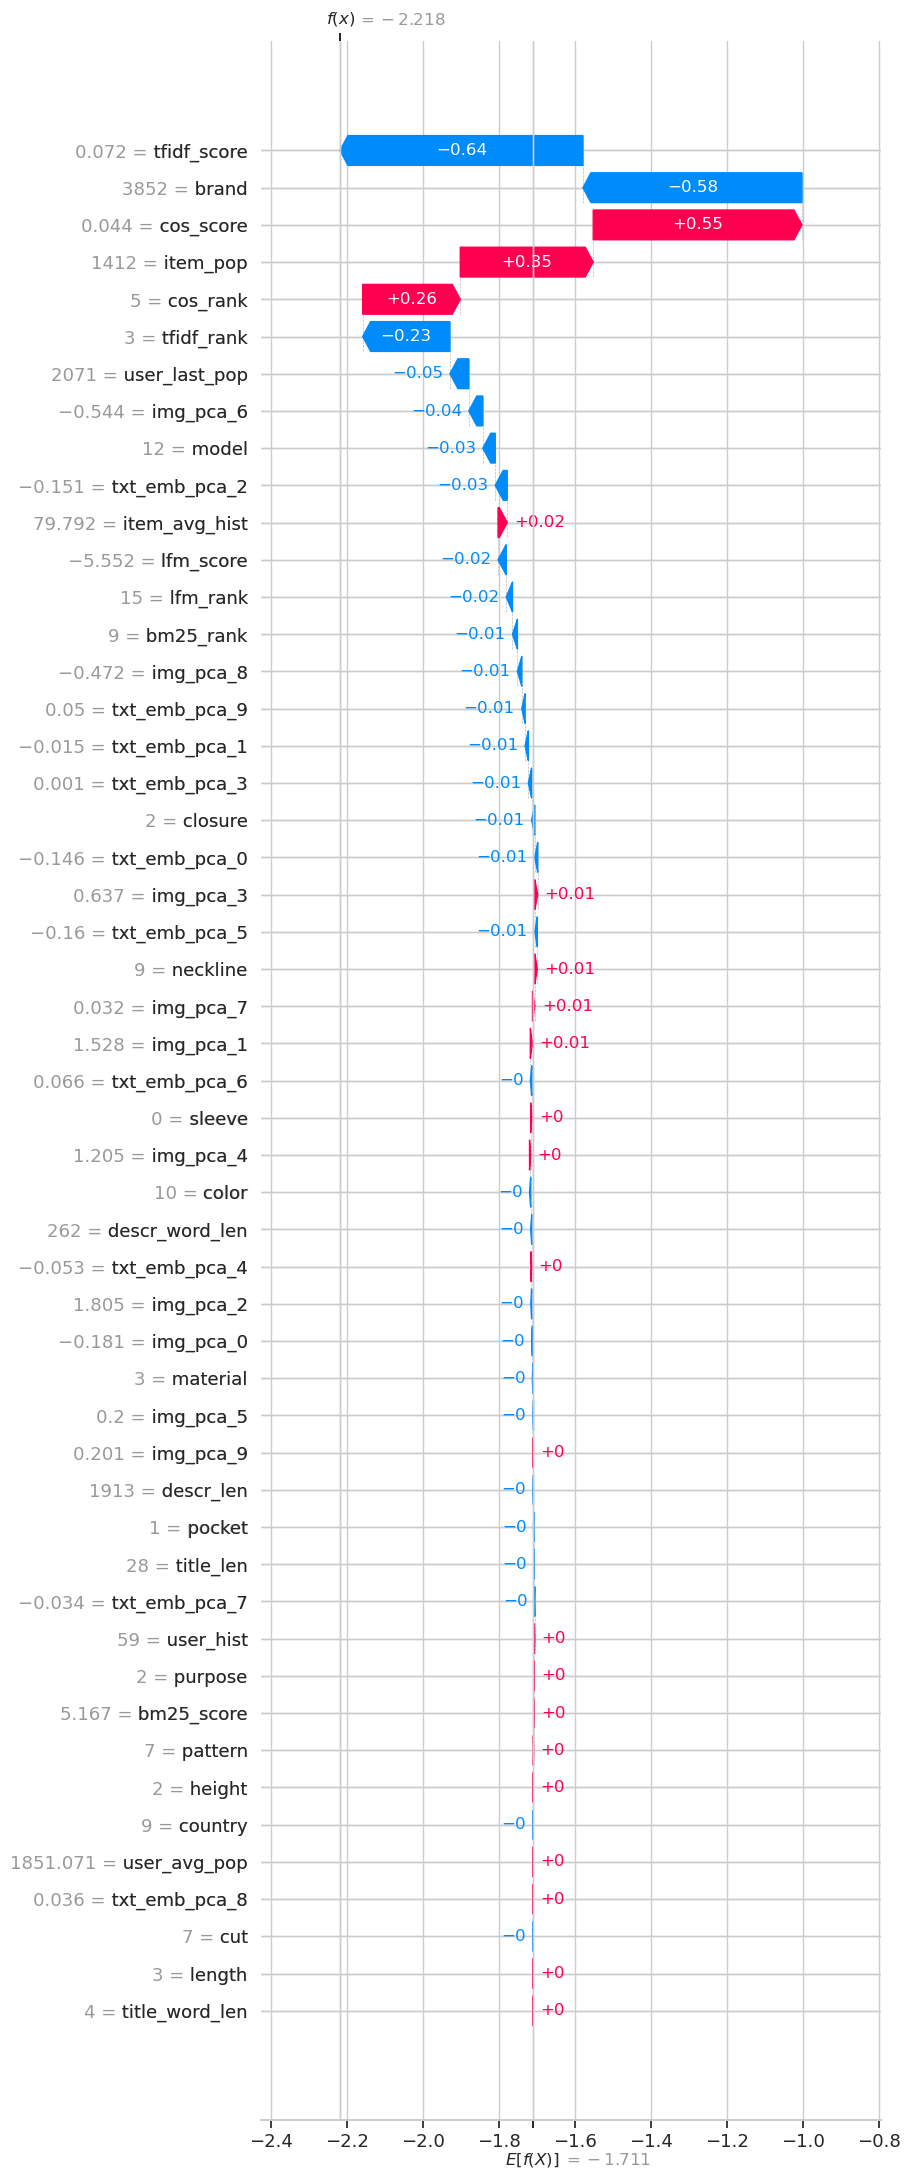

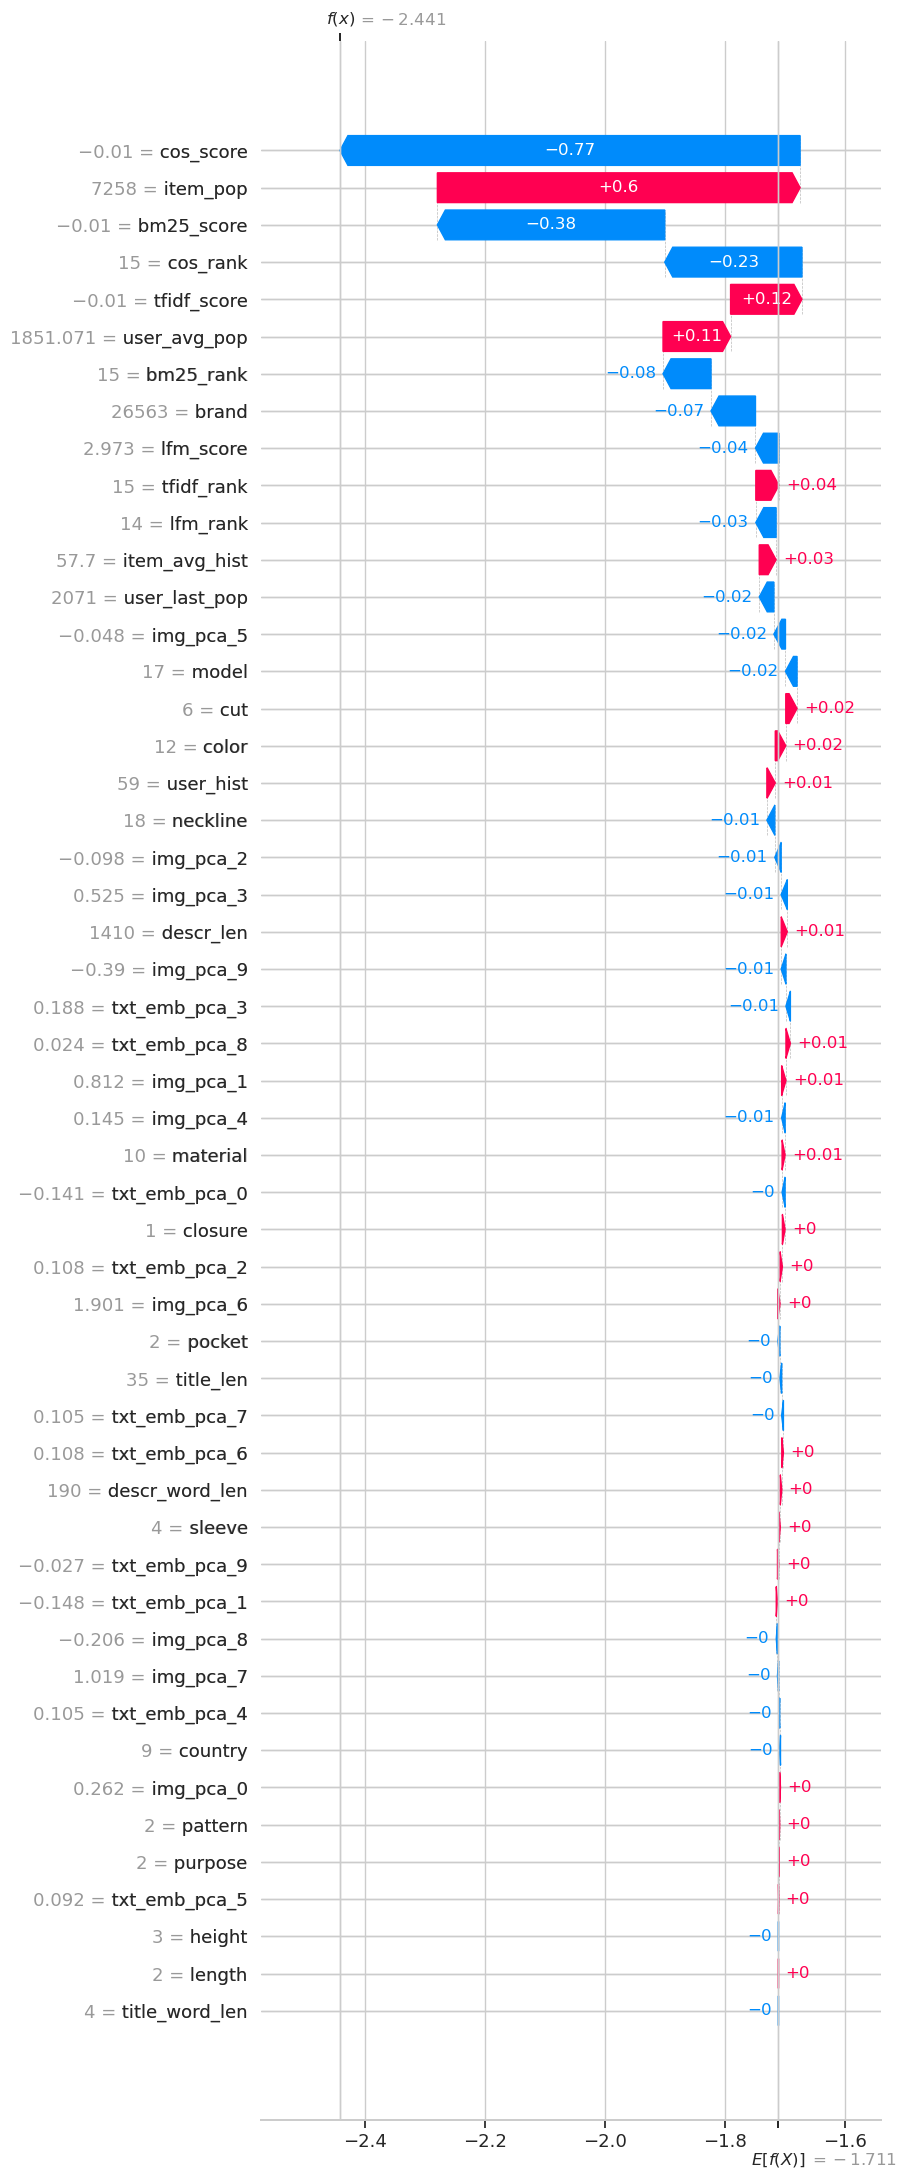

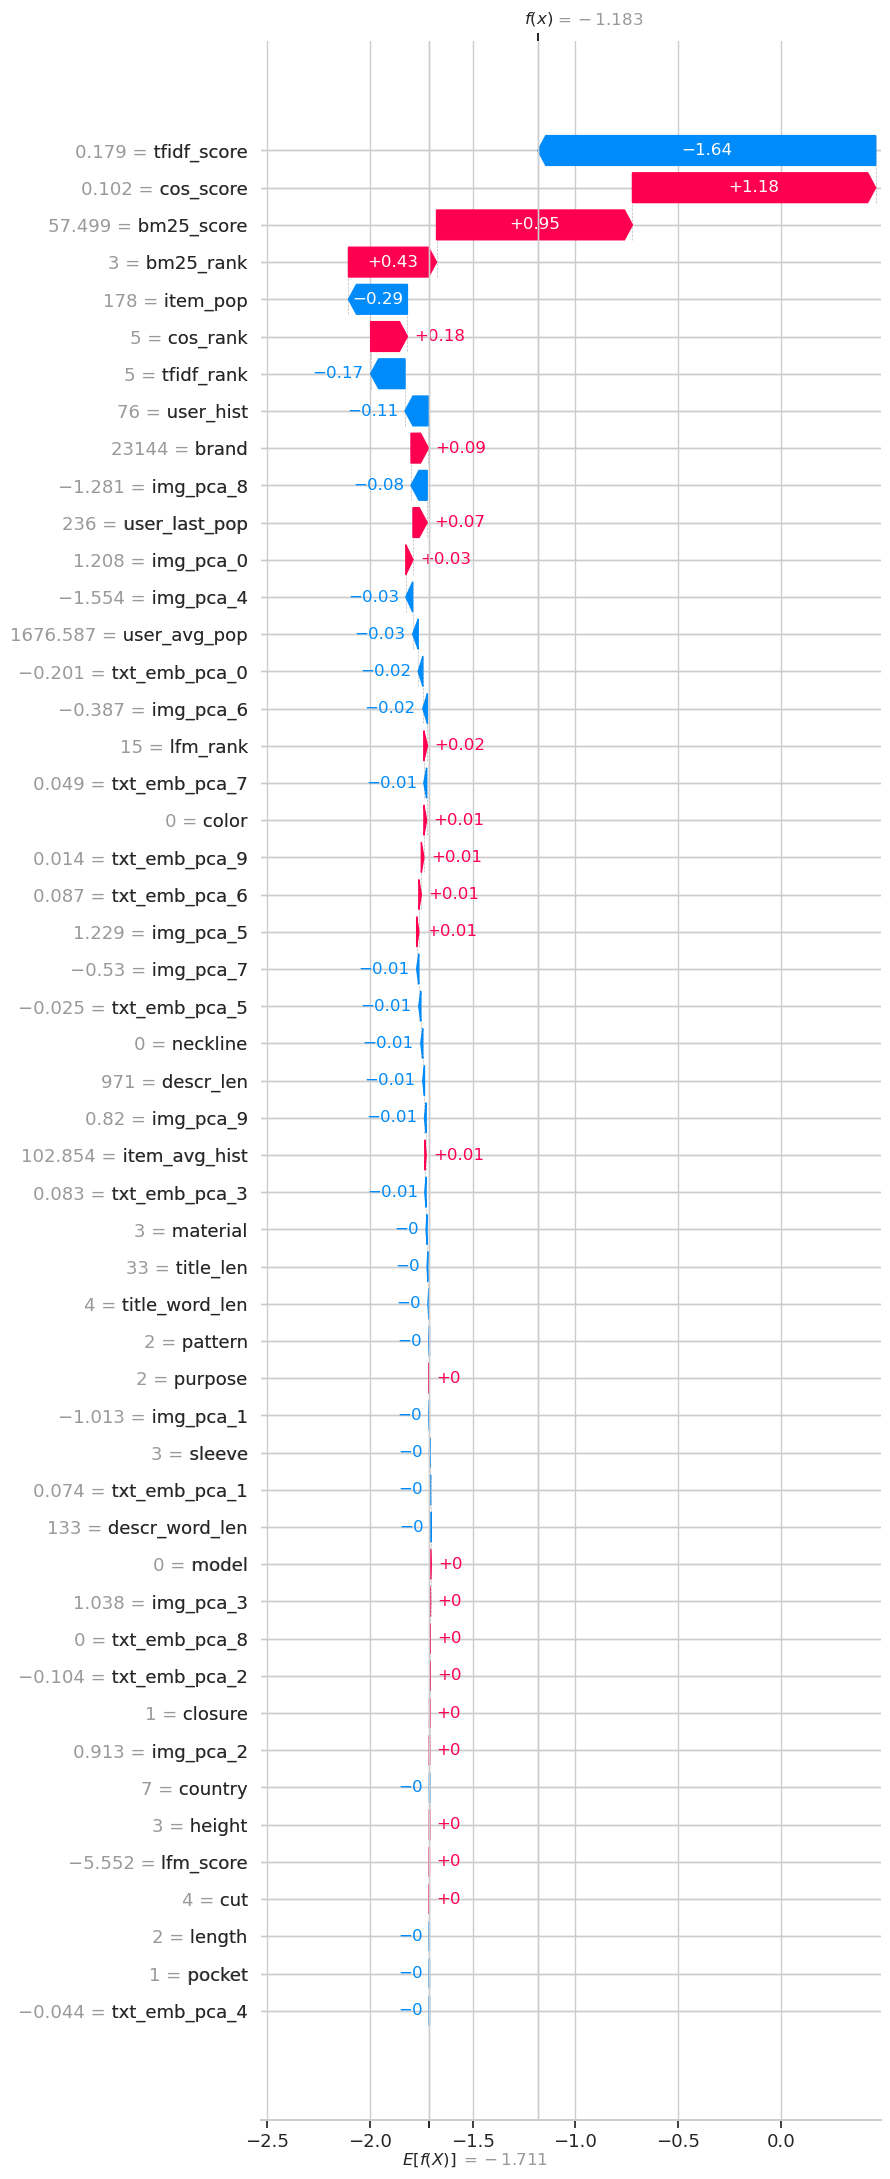

In [13]:
shap.plots.waterfall(shap_values[0], max_display=len(FEATURES))
shap.plots.waterfall(shap_values[1], max_display=len(FEATURES))
shap.plots.waterfall(shap_values[200], max_display=len(FEATURES))

#### beeswarm plot

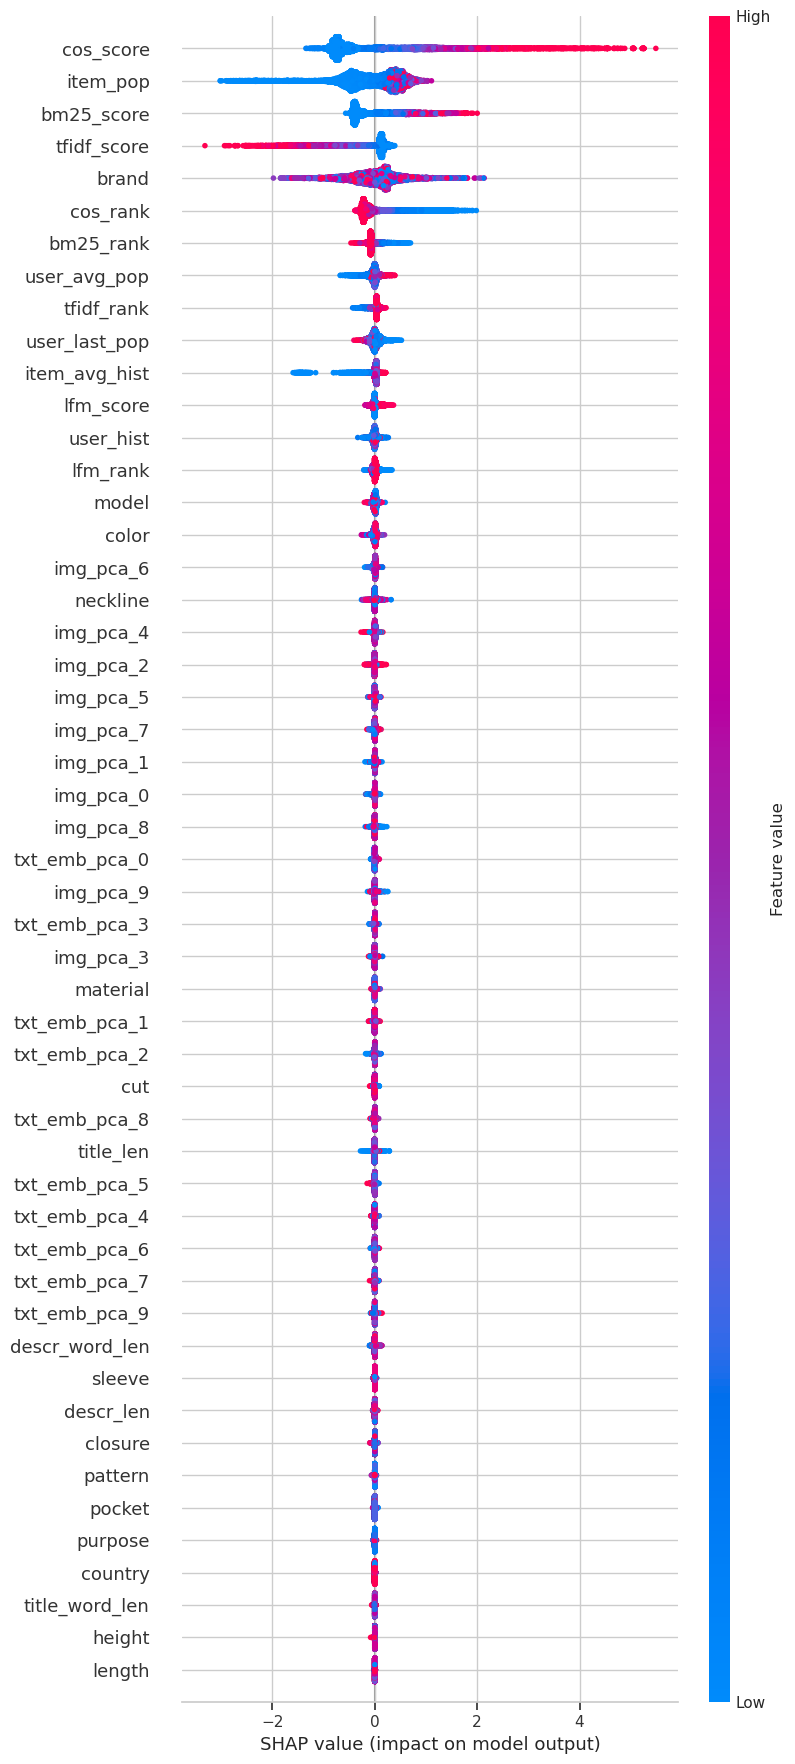

In [14]:
# summarize the effects of all the features
shap.plots.beeswarm(shap_values, max_display=len(FEATURES))

### bar plot

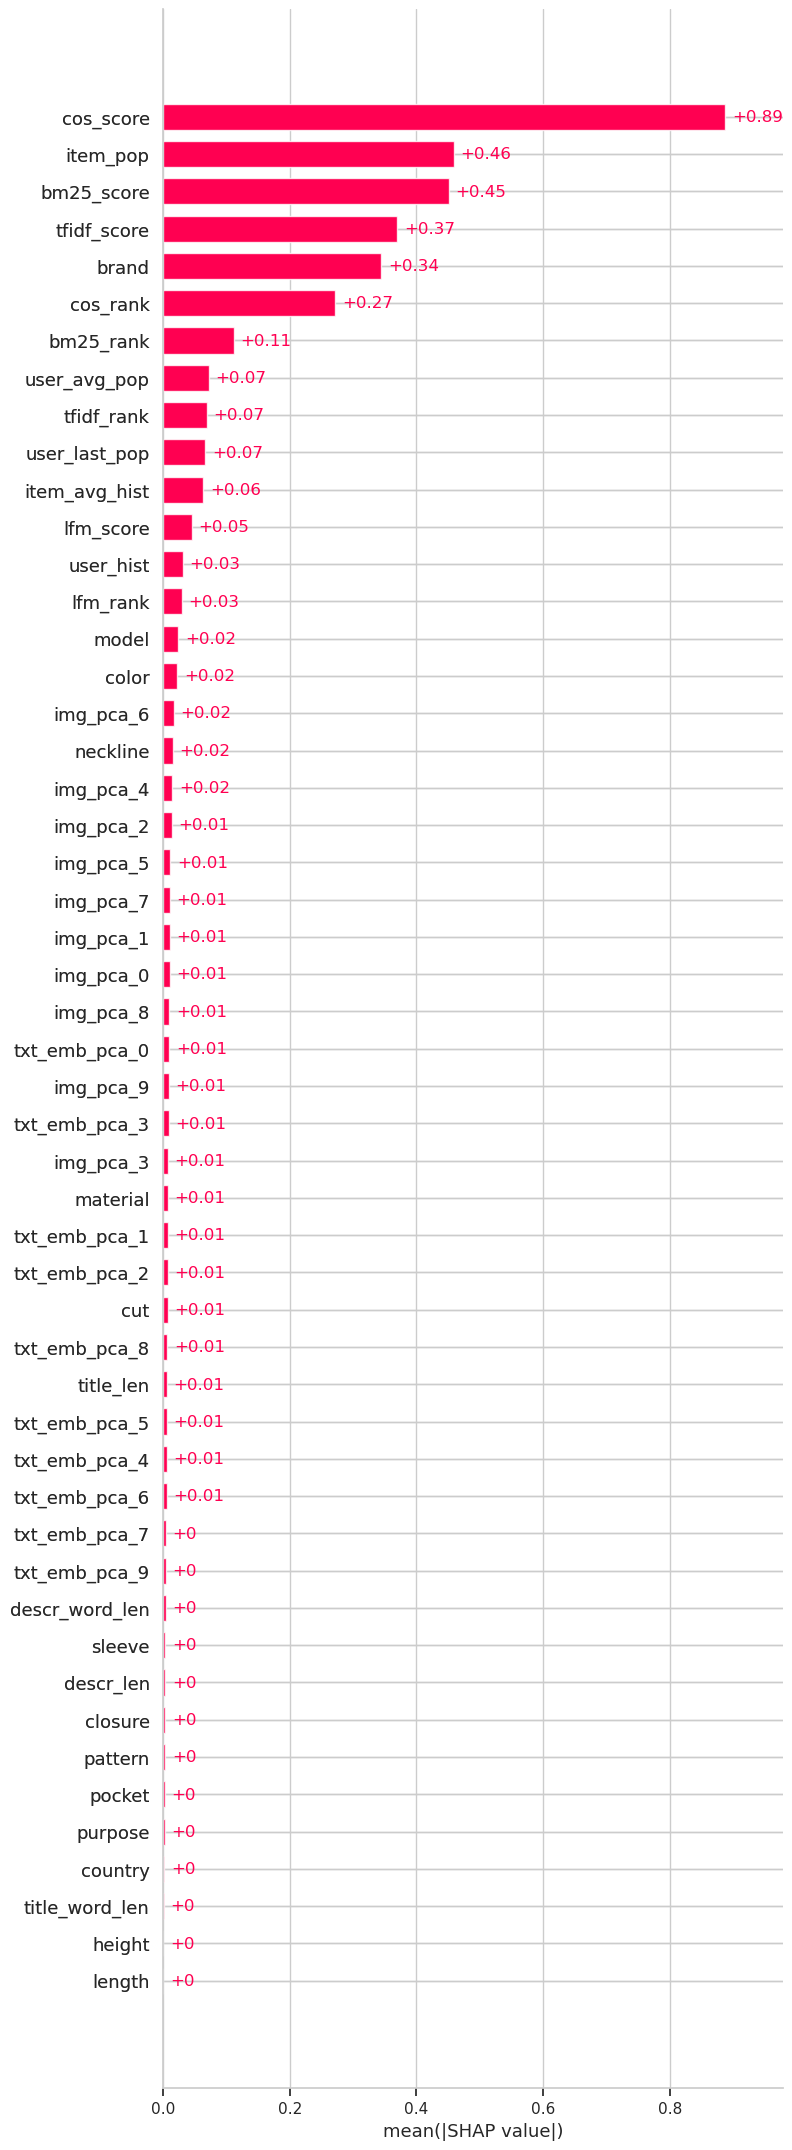

In [15]:
# mean shap-values
shap.plots.bar(shap_values, max_display=len(FEATURES))

### Feature importance plot

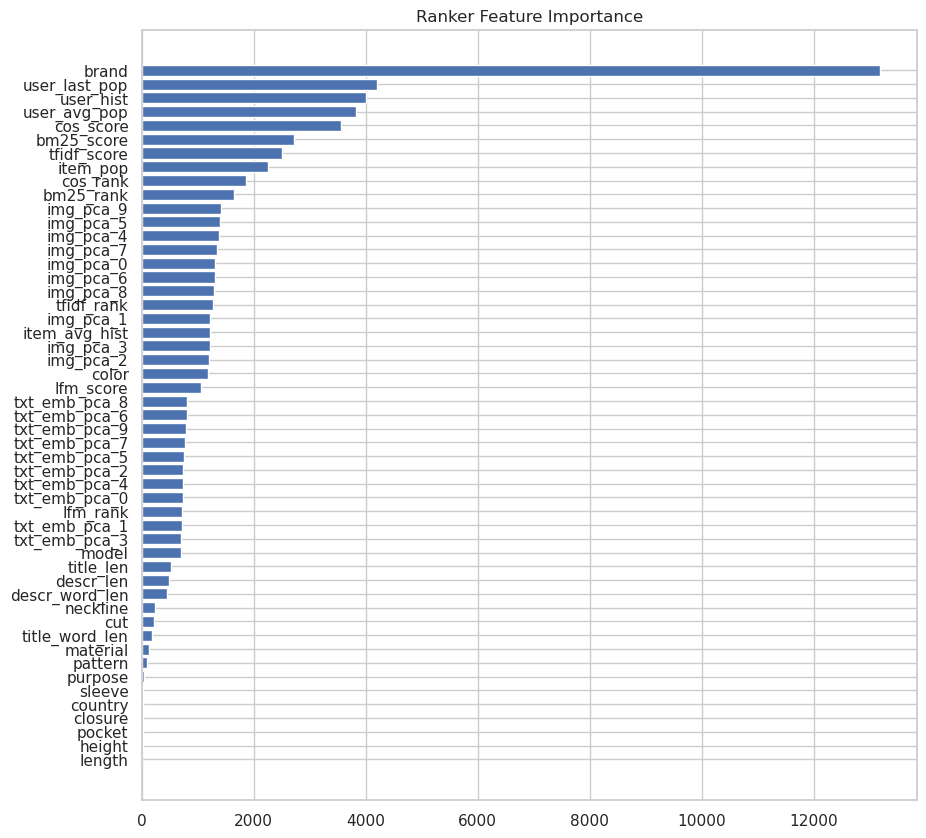

In [16]:
sorted_idx = np.argsort(listwise_model.feature_importances_)
fig = plt.figure(figsize=(10, 10))
plt.barh(range(len(sorted_idx)), listwise_model.feature_importances_[sorted_idx], align='center')
plt.yticks(range(len(sorted_idx)), np.array(FEATURES)[sorted_idx])
plt.title('Ranker Feature Importance')
plt.show()

## Выдаем рекомендации


In [5]:
# Загрузим listwise_model
with open(models_path + "LGBM_ranker_model.dill", "rb") as f:
    listwise_model = dill.load(f)

In [6]:
# Загрузим таблицу ranker_test
with open(data_path + "ranker_test_final.dill", "rb") as f:
    ranker_test = dill.load(f)

In [8]:
y_pred: np.ndarray = listwise_model.predict(ranker_test[FEATURES])

In [ ]:
ranker_test = add_score_and_rank(ranker_test, y_pred, "listwise")
ranker_test.head(3)

In [10]:
# Dump listwise_model predictions for users
with open(candidates_data_path + "LGBM_ranker_predictions.dill", "wb") as f:
    dill.dump(ranker_test, f)

## Считаем метрики

In [ ]:
predictions = (
    ranker_test[ranker_test["listwise_hybrid_rank"] <= 15][["user_id", "item_id"]]
    .groupby(by="user_id")["item_id"]
    .apply(list)
    .reset_index()
    .rename(columns={"item_id": "listwise_hybrid_rank_recs"})
)
predictions

In [ ]:
# Загружаем таблицу test_df
with open(data_path + "test_df.dill", "rb") as f:
    test_df = dill.load(f)
    
test_df

In [ ]:
test_df = pd.merge(
    test_df[test_df["user_id"].isin(predictions["user_id"].unique())],
    predictions,
    how="left",
    on="user_id",
)
test_df

In [19]:
for k in [3, 5, 10, 15]:
    print(
        f"""k = {k}: {RecommenderMetrics.evaluate_recommender(
            test_df, model_preds_col="listwise_hybrid_rank_recs", k=k
        )}\n"""
    )

k = 3: {'ndcg@k': 0.24337883215021727, 'recall@k': 0.14280810723708978, 'map@k': 0.16964205058717252}

k = 5: {'ndcg@k': 0.2749679666949889, 'recall@k': 0.1669949535955028, 'map@k': 0.1568037040358149}

k = 10: {'ndcg@k': 0.3132143409075014, 'recall@k': 0.19805558496264275, 'map@k': 0.14855146634270994}

k = 15: {'ndcg@k': 0.33310114733891083, 'recall@k': 0.21516660549931535, 'map@k': 0.1466839603690634}



# Выводы

Подбором параметров удалось улучшить метрики.
Но инференс модели стал достаточно долгим в следствие увеличения n_estimators.